### Introduction

To warm up in PyTorch, we're making a pretty project with lots of batched linear operations: Triangle Rendering!

We're going to render a binary (triange | no triangle) image for one triangle, render all the triangles at once in a batch, and then combine them, and then more than just binary (triangle | no triangle).


Here's our model of the world: the "camera" is a point with a grid of lines pointing out of it - each of these corresponds to one pixel in the camera's image. Out there are a bunch of triangles, each specified by three points. In order to find the color of each pixel, we'll check whether the line coming from the camera intersects with the area of any of the the triangles. Then we can color the pixel based on some information about that triangle that the line hit.

![image](https://www.scratchapixel.com/images/upload/rasterization/raytracing-raster.png?)

### Before we render 2d images, lets render 1d images

Here, instead of checking whether a 2d grid of rays intersects with triangles, we will check whether a 1d fan of rays intersects with lines.

We will use 3 dimensions, but the last dimension will always be 0 for now. Let's have our camera at (0,0,0), and its rays will be ((0,0,0), (1, -1, 0)), (0,0,0), (1, -0.9, 0)), ect.

Make the function
```
make_rays_1d(width_pixels: int, fov_ratio)
->
FloatTensor[width_pixels (number of lines), 2 (points per line), 2 (scalars per point)]
```
that creates a lines going from the camera (origin) in each pixel direction. fov_ratio means "how wide of a thing that's 1 unit away can I see?". At fov_ratio=1, you can see 1-unit-wide things that are 1 unit away, and so on.

Once you think you've made it correctly, run the `render_lines_with_pyplot` function we provide on your lines tensor. It should look like this: 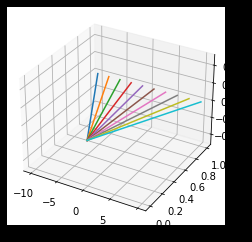.

In [1]:
import torch as t
import einops
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
from ipywidgets import interact

def render_lines_with_pyplot(lines):
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'})

    for line in lines:
        ax.plot(line[:,1].numpy(), line[:,0].numpy(), line[:,2].numpy())

    plt.show()

In [2]:
# SOLUTION, TO REMOVE
def make_rays_1d(W,fov_ratio=0.3):
    y_dirs = t.linspace(-fov_ratio,fov_ratio, W)
    ray_directions = t.stack([t.ones(W), y_dirs,t.zeros(W)], dim=1)
    origin = t.tensor([0,0,0]).unsqueeze(0).expand([W, 3])
    lines = t.stack([origin, ray_directions], dim=1)
    return lines

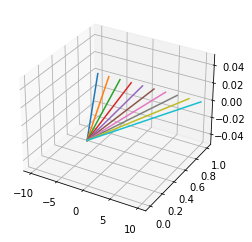

In [24]:
lines = make_rays_1d(10, 10.)

render_lines_with_pyplot(lines)

### Now let's check whether our camera lines intersect with our object lines

This has two steps: find the point where the two (infinite euclidean) lines intersect by solving a linear equation, and then check whether that point is inside the line segments.

Our camera line is defined by points $R_1$ and $R_2$, and our object line is defined by points $O_1$ and $O_2$.

We can write the equations for all points on the camera line as $R(u)=R_1+u(R_2 - R_1)$ and on the object lines as $O(v)=O_1+v(O_2 - O_1)$ for $u, v \in [0, 1]$.

In [46]:
@interact
def line(s=(-2.0, 2.0), seed=(0, 10)):
    t.manual_seed(seed)
    R_1 = t.randn(2)
    R_2 = t.randn(2)
    D = R_2 - R_1
    P = lambda a : R_1 + a * D
    x, y = zip(P(-2), P(2))
    plt.plot(x, y, 'g-')
    plt.plot(*R_1, 'ro', markersize=12)
    plt.plot(*R_2, 'ro', markersize=12)
    plt.plot(P(s)[0], P(s)[1], '*', markersize=12)

interactive(children=(FloatSlider(value=0.0, description='s', max=2.0, min=-2.0), IntSlider(value=5, descripti…

Setting the line equations from above equal:
\begin{align}
R_1+u(R_2 - R_1) &= O_1 + v(O_2 - O_1) \\
u(R_2 - R_1) - v(O_2 - O_1) &= O_1 - R_1  \\
\begin{pmatrix}
(R_2 - R_1)_x & (O_1 - O_2)_x \\
(R_2 - R_1)_y & (O_1 - O_2)_y \\
\end{pmatrix}
\begin{pmatrix}
u \\
v \\
\end{pmatrix}
&= 
\begin{pmatrix}
(O_1 - R_1)_x \\
(O_1 - R_1)_y \\
\end{pmatrix}
\end{align}


Once we've found values of $u$ and $v$ which satisfy this equation (if any, the lines could be parallel) we just need to check that $u, v \in [0, 1]$.

Here are some objects:

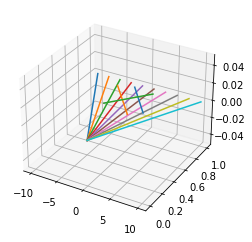

In [5]:
def get_objects(n, seed=8):
    t.manual_seed(seed)
    xys = t.rand(n, 2, 2)
    xys[:,:,1]-=0.5
    xys[:,:,1]*=10
    return t.cat([xys, t.zeros(n, 2, 1)], dim=2)

objects = get_objects(3)

render_lines_with_pyplot(t.cat([lines, objects], dim=0))

**Step:** Using `torch.linalg.solve` and `torch.stack`, write the function
```
intersect_ray_1d(ray, obj) -> bool
```
which returns true if the ray and object intersect.

Keep in mind that your code only needs to work when then the z-dim is 0 (you can also assume that rays and objects aren't parallel).

In [6]:
# SOLUTION, TO REMOVE
def intersect_ray_1d(ray, obj):
    ray = ray[:, :2]
    obj = obj[:, :2]

    R_1 = ray[0]
    R_2 = ray[1]

    O_1 = obj[0]
    O_2 = obj[1]

    A = t.stack([R_2 - R_1, O_1 - O_2], dim=1)
    B = O_1 - R_1

    sol = t.linalg.solve(A, B)

    return (0 <= sol).all() and (sol <= 1).all()

In [7]:
print(intersect_ray_1d(lines[3], objects[0])) # should be False
print(intersect_ray_1d(lines[4], objects[0])) # should be True

tensor(False)
tensor(True)


Now let's batch process rays and objects with the function 
```
intersect_rays_1d(rays, objs) -> BoolTensor[num rays]
```
Where the output is true if there is some object which intersects with that ray. You'll probably want to use `einops.repeat`. This should look very similar to the non-batch version.

In [54]:
# SOLUTION, TO REMOVE
def intersect_rays_1d(rays: t.Tensor, objs):
    rays = rays[..., :2]
    objs = objs[..., :2]

    rays = einops.repeat(rays, 'n_r p d -> n_r n_o p d', n_o=objs.size(0))
    objs = einops.repeat(objs, 'n_o p d -> n_r n_o p d', n_r=rays.size(0))

    R_1 = rays[:, :, 0]
    R_2 = rays[:, :, 1]

    O_1 = objs[:, :, 0]
    O_2 = objs[:, :, 1]

    A = t.stack([R_2 - R_1, O_1 - O_2], dim=-1)
    B = O_1 - R_1

    sol = t.linalg.solve(A, B)

    return (t.logical_and((0 <= sol).all(axis=-1),
                          (sol <= 1).all(axis=-1))).any(axis=-1)

In [9]:
print(intersect_rays_1d(lines, objects))
# should be tensor([False, False,  True,  True,  True,  True,  True,  True, False, False])

tensor([False, False,  True,  True,  True,  True,  True,  True, False, False])


### Now, lets generate a 2d grid of camera lines

Make a function

```
make_rays_2d(width_pixels: int, height_pixels: int, h_aspect_ratio = 0.3, w_aspect_ratio = 0.3)
->
FloatTensor[width_pixels * height_pixels (number of lines), 2 (points per line), 3 (scalars per point)]
```
that creates a lines going from the camera (origin) in each pixel direction. h_aspect_ratio means "how wide of a thing that's 1 unit away can I see?". at h_aspect_ratio=1, you can see 1-unit-wide things that are 1 unit away, and so on.

Once you think you've made it correctly, run the `render_lines_with_pyplot` function we provide on your lines tensor (see below cell). It should look like a bunch of evenly spaced lines in a pyramid.

In [10]:
# SOLUTION, TO REMOVE
def make_rays_2d(W, H, width_scale=0.3, height_scale=0.3):
    n_pixels = W*H
    x_dirs = t.linspace(-width_scale, width_scale, W).unsqueeze(0).expand([H, W]).reshape([n_pixels])
    y_dirs = t.linspace(-height_scale,height_scale, H).unsqueeze(1).expand([H, W]).reshape([n_pixels])
    ray_directions = t.stack([t.ones(n_pixels), x_dirs, y_dirs], dim=1)
    origin = t.tensor([0,0,0]).unsqueeze(0).expand([n_pixels, 3])
    lines = t.stack([origin, ray_directions], dim=1)
    return lines

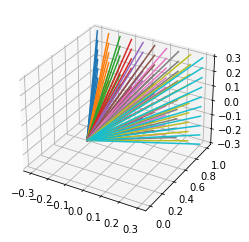

In [11]:
lines = make_rays_2d(10,10)
render_lines_with_pyplot(lines)

### Now

### Triangle coordinates

Analogously to a line, the area inside a triangle can be defined by three (non-colinear) points $A$, $B$ and $C$, and can be written algebraically as:

$$P(w, u, v) = wA + uB + vC$$
$$s.t.$$
$$0 \leq w,u,v$$
$$w + u + v = 1$$

Or equivalently:

$$P(u, v) = (1 - u - v)A + uB + vC =$$
$$P(u, v) = A + u(B - A) + v(C - A)$$
$$s.t.$$
$$0 \leq u,v$$
$$u + v \leq 1$$

These $u, v$ are called "barycentric coordinates".

If we remove the bounds on $u$ and $v$, we get an equation for the plane containing the triangle.

In [52]:
one_triangle = t.Tensor([[0, 0, 0], [3, 0.5, 0], [2, 3, 0]])

@interact
def triangle(u=(-1.0, 2.0), v=(-1.0, 2.0)):
    A = one_triangle[0]
    B = one_triangle[1]
    C = one_triangle[2]
    for p in (A, B, C):
        plt.plot(p[0], p[1], 'ro', markersize=12)
    for p, q in ((A,B),(B,C),(C,A)):
        x, y, _ = zip(p, q)
        plt.plot(x, y, 'g-')
    P = A + u*(B-A) + v*(C-A)
    plt.plot(P[0], P[1], '*', markersize=12)


interactive(children=(FloatSlider(value=0.5, description='u', max=2.0, min=-1.0), FloatSlider(value=0.5, descr…

### Triangle-line intersection

Our intersection algorithm will thus consist of two steps:
* Finding the intersection between the line and the plane containing the triangle, by solving the equation $P(s) = P(u, v)$;
* Checking if $u$ and $v$ are within the bounds of the triangle.

Expanding the equation $P(s) = P(u, v)$, we have:

$$O + sD = A + u(B - A) + v(C - A) \Rightarrow$$

\begin{gather}
\Rightarrow
\begin{pmatrix}
-D & (B - A) & (C - A) \\
\end{pmatrix}
\begin{pmatrix}
s \\
u \\
v 
\end{pmatrix}
=
\begin{pmatrix}
(O - A)
\end{pmatrix}
\Rightarrow
\end{gather}

\begin{gather}
\Rightarrow
\begin{pmatrix}
-D_x & (B - A)_x & (C - A)_x \\
-D_y & (B - A)_y & (C - A)_y \\
-D_z & (B - A)_z & (C - A)_z \\
\end{pmatrix}
\begin{pmatrix}
s \\
u \\
v 
\end{pmatrix}
=
\begin{pmatrix}
(O - A)_x \\
(O - A)_y \\
(O - A)_z \\
\end{pmatrix}
\end{gather}

We can therefore find the coordinates `s`, `u`, `v` of the intersection point by solving the linear system above.

In [13]:
import numpy as np
import torch as t
import matplotlib.pyplot as plt

Again using `torch.linalg.solve` and `torch.stack`, write a function `triangle_line_intersects(A, B, C, O, D)` that receives a single triangle's vertices `A`, `B`, `C`; a line's point `O` and direction `D` (all as torch tensors of shape `[3]`); and returns a boolean value as to whether they intersect or not. This can be done reasonably in two lines of code.

In [53]:
# SOLUTION, TO REMOVE
def triangle_line_intersects(A, B, C, O, D):
  s, u, v = t.linalg.solve(t.stack([-D, B-A, C-A], dim=1), O-A)
  return (0 < u) & (0 < v) & (u + v < 1)

*Optional: the suggested implementation will fail if the line is parallel to the triangle's plane. Think of simple ways for making an implementation that covers this case.*

### Camera

To define our field of vision, we will use the abstraction of a `Camera`, defining the origin and direction of the light rays, and a viewport resolution.

In [15]:
def normalize(x):
  return x / t.sqrt(t.sum(x**2, dim=-1, keepdim=True))

def _get_rotation(forward):
  forward = normalize(forward)
  right = t.cross(t.tensor([0.0, 1.0, 0.0]), forward)
  up = t.cross(forward, right)
  R = normalize(t.stack([right, up, forward], axis=0))
  def rotate(x):
    return t.einsum('ij,...i->...j', R, x)
  return rotate

class Camera:
  def __init__(self, *, origin=None, direction=None, target=None, height=60, width=50):
    if origin is None:
      origin = t.zeros(3)
    if direction is None:
      direction = t.tensor([0.0, 0.0, 1.0])
    if target is not None:
      direction = target - origin

    self.origin = origin
    self.height = height
    self.width = width
    self.direction = normalize(direction)
    self.x_angle = np.pi / 4

  def pixel_rays(self):
    H = self.height
    W = self.width
    x_bound = np.tan(self.x_angle / 2)
    y_bound = H/W * x_bound

    viewport_grid = t.ones(H, W, 3)
    viewport_grid[t.arange(H), :, 1] = t.linspace(-y_bound, y_bound, H)[:, None]
    viewport_grid[:, t.arange(W), 0] = t.linspace(-x_bound, x_bound, W)
    D = _get_rotation(self.direction)(viewport_grid)
    D = normalize(D)
    return D

### Single-triangle rendering

For raytracing a triangle, we will simply check for triangle-line intersections for all light rays at once.

Step: implement a function `raytrace_triangle(triangle, camera)` that receives a `triangle` (a tensor of size `[3, 3]`) and a `camera` object, and returns a tensor with each entry corresponding to the presence of a triangle on that pixel (1 if there is a triangle, and 0 otherwise). Use a single batch call to `torch.linalg.solve`. Visualize the result with `plt.imshow`.
* Your function is expected to look similar to `triangle_line_intersects`, with some preprocessing and postprocessing around the call to `solve`.
* It is suggested to use `torch.reshape` and `torch.repeat` to process tensor shapes.


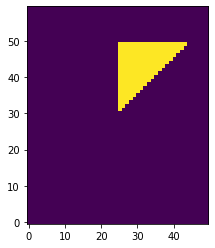

In [16]:
### Reference code, to be removed in handout
def raytrace_triangle(triangle, camera):
  H = camera.height
  W = camera.width
  N = H*W

  O = camera.origin
  D = camera.pixel_rays()
  D = D.reshape(N, 3)

  A, B, C = triangle
  A = A.repeat(N, 1)
  B = B.repeat(N, 1)
  C = C.repeat(N, 1)

  x = t.linalg.solve(t.stack([-D, B-A, C-A], dim=2), O-A)
  u = x[:, 1]
  v = x[:, 2]

  intersects = (0 < u) & (0 < v) & (u + v < 1)
  intersects = intersects.reshape(H, W)
  return intersects

point = t.tensor([0.0, 0.0, 3.0])
camera = Camera(direction=point)
triangle = point + t.tensor([[0, 0, 0.0], [0, 1, 0.0], [1, 1, 0.0]])
view = raytrace_triangle(triangle, camera)
plt.imshow(view, origin='lower')

### Mesh rendering

For raytracing a mesh, we will find the intersection points for all pixel rays and all triangles at once.

In [17]:
!pip install -q numpy-stl

In [18]:
!wget -O pikachu-flowalistik.STL -q https://cdn.thingiverse.com/assets/80/10/f0/76/fb/pikachu_1gen_flowalistik.STL

SSL_INIT


In [19]:
from stl import mesh
model = mesh.Mesh.from_file('pikachu-flowalistik.STL')
triangles = t.tensor(model.vectors.copy())
triangles[:, :, [2, 0, 1]] = triangles.clone()

Step: implement a function `raytrace_mesh(triangles, camera)` that receives the `triangles` of a mesh (a tensor of size `[T, 3, 3]`) and a `camera` object, and returns a tensor with the distance to the mesh at that pixel (let the distance be infinite if there is no intersection); Use a single batch call to `torch.linalg.solve`. Visualize the result with `plt.imshow`.
* Your function is expected to look similar to `raytrace_triangle`.
* Target the camera towards the barycenter of the mesh.

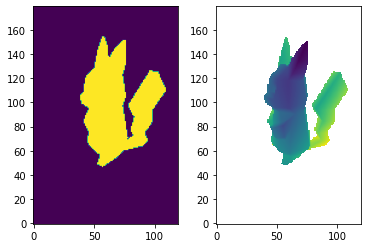

In [20]:
### Reference code, to be removed in handout
def raytrace_mesh(triangles, camera):
  H = camera.height
  W = camera.width

  N = H*W
  T = len(triangles)

  O = camera.origin
  D = camera.pixel_rays()
  D = D[:, :, None, :].repeat(1, 1, T, 1).reshape(N*T, 3)

  A = triangles[:, 0].repeat(N, 1)
  B = triangles[:, 1].repeat(N, 1)
  C = triangles[:, 2].repeat(N, 1)

  x = t.linalg.solve(t.stack([-D, B-A, C-A], dim=2), O-A)

  s = x[:, 0]
  u = x[:, 1]
  v = x[:, 2]

  intersects = (0 < u) & (0 < v) & (u + v < 1)

  dists = s.clone()
  dists[~intersects] = float('inf')
  dists = dists.reshape(H, W, T).amin(-1)
  return dists

fig, axes = plt.subplots(1, 2)
axes = axes.flatten()

mesh_center = triangles.mean(dim=(0, 1))

origin = mesh_center + t.tensor([-25.0, 30.0, -80.0])
camera = Camera(origin=origin, target=mesh_center, height=180, width=120)

dists = raytrace_mesh(triangles, camera)
intersects = t.isfinite(dists)
axes[0].imshow(intersects, origin='lower')
axes[1].imshow(dists, origin='lower')

### Vectorizing it further

In [21]:
!pip install -q mediapy

In [22]:
from PIL import Image
import mediapy as media

We can just keep vectorizing! We will now make a video rotating around our model mesh.


Step: Write a function `multirender_mesh(triangles, camera, origins)`, behaving similar to `render_mesh`, with the change that it accepts a parameter `origins`, corresponding to different positions of the camera, and returns the distances to the model for each origin and pixel. Use a single call to `torch.linalg.solve`. Use this function to make a video rotating around the model.

In [23]:
### Reference code, to be removed in handout
def multirender_mesh(triangles, camera, origins):
  H = camera.height
  W = camera.width

  target = mesh_center

  N = H*W
  nO = len(origins)
  T = len(triangles)

  O = t.stack(origins, dim=0) # (n0, 3)
  O = O[:, None, :].repeat(1, N*T, 1).reshape(nO*N*T, 3) # (n0*N, 3)

  Ds = []
  for origin in origins:
    camera.direction = target - origin
    D = camera.pixel_rays()
    D = D[:, :, None, :].repeat(1, 1, T, 1).reshape(N*T, 3)
    Ds.append(D)
  D = t.stack(Ds, dim=0).reshape(-1, 3) # (nO*H*W*T, 3)

  A = triangles[:, 0].repeat(N*nO, 1)
  B = triangles[:, 1].repeat(N*nO, 1)
  C = triangles[:, 2].repeat(N*nO, 1)

  x = t.linalg.solve(t.stack([-D, B-A, C-A], dim=2), O-A)

  s = x[:, 0]
  u = x[:, 1]
  v = x[:, 2]

  intersects = (0 < u) & (0 < v) & (u + v < 1)

  dists = s.clone()
  dists[~intersects] = float('inf')
  dists = dists.reshape(nO, H, W, T).amin(-1)

  return dists

nO = 45

mesh_center = triangles.mean(dim=(0, 1))
triangles -= mesh_center
origins = [t.tensor([-40.0*np.cos(a), 30.0, -100.0*np.sin(a)]).float() for a in np.linspace(0, 2*np.pi, nO)]

camera = Camera(target=mesh_center, height=60, width=40)
dists = multirender_mesh(triangles, camera, origins)

for i, dist in enumerate(dists):
  plt.imshow(dist, origin='lower')
  plt.axis('off')
  plt.savefig(f'/tmp/{i}.png', bbox_inches='tight')
  plt.close()

frames = []
for i in range(len(dists)):
  img = Image.open(f'/tmp/{i}.png')
  frame = np.asarray(img)
  frames.append(frame[:, :, :3])
frames = np.stack(frames)
media.show_video(frames, fps=15)